In [1]:
#Assignment 3

#%% Import Packages
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn
import sklearn.neural_network as nn
import scipy.optimize
plt.close('all')


In [2]:
#importing functions

def MysteriousLoadFunc(X):
    import numpy as np
    Alsq = np.array([-8.49821625e+03,  3.21111941e+03, -3.44642937e+03, -8.33496535e+02,
       -2.28585769e+02,  7.27203251e+03,  9.25677112e+02,  1.16755478e+02,
        1.18918605e+03,  5.07954840e+00, -3.79944018e+03, -3.99715920e+01,
        7.18288327e+01, -1.82188802e+02, -2.61134584e+00, -2.53566886e+02,
        1.11035167e+03,  8.03450614e+00, -1.49376926e+02,  6.50965086e+00])

    X1 = X[:,0]
    X2 = X[:,1]
    X3 = X[:,2]
    X0 = np.ones(X1.shape)
    Xmatrix = np.array((X0,X1,X2,X3,X1**2,X2**2,X1*X2,X1*X3,X2*X3,X1**3,X2**3,(X1**2)*X2, (X1**2)*X3, \
                       (X2**2)*X1,(X2**2)*X3,X1*X2*X3, X2**4, (X1**2)*(X2**2), X2**5, X2**6)).T

    Y = np.dot(Xmatrix,Alsq) + 50e3 + np.random.randn(X0.shape[0])*4.0e3
    return Y

# Helper functions - normal distribution

# Normal distribution
def NormalDist(task,x,mu=0,sigma=1):
    import numpy as np
    if task == 0: # PDF
        y = (1.0/(sigma*np.sqrt(2.0*np.pi)))*np.exp(-((x - mu)**2)/(2.0*(sigma**2)))
    elif task == 1: # Cumulative
        from scipy.special import erf
        y = 0.5*(1.0 + erf((x - mu)/(sigma*np.sqrt(2))))
    elif task == 2: # Inverse
        from scipy.special import erfinv
        y = mu + sigma*np.sqrt(2)*erfinv(2*x - 1)        
    return y


# Helper functions - lognormal distribution
def LogNormDist(task,x,mu,sigma):
    import numpy as np
    Eps   = np.sqrt(np.log( 1.0+(sigma/mu)**2 ) )
    Ksi   = np.log(mu)-0.5*Eps**2
    if task == 0: # PDF
        x[x<=0] = 1e-8
        u =(np.log(x)-Ksi)/Eps
        y = np.exp(-u*u/2.0)/(Eps*x*np.sqrt(2.0*np.pi))
    elif task == 1: # Cummulative
        x[x<=0] = 1e-8
        u =(np.log(x)-Ksi)/Eps
        y= NormalDist(1, u)
    elif task == 2: # Inverse
        y= np.exp(Ksi+Eps*NormalDist(2, x))
    
    return y

# recycle the handy rosenblatt function, that creates the data
def rosenblatt(N, Aweib=11.28, Kweib=2, Iref=0.14, c_alpha=0.088):
    
    #--> for shear alpha
    MuAlphaFunc = lambda u: c_alpha*(np.log(u) - 1) #takes u, yields mu_alpha
    SigmaAlphaFunc = lambda u: 1/u

    #--> for turbulence sigma
    MuSigmaFunc = lambda u: Iref*(0.75*u + 3.8)
    SigmaSigmaU = 2.8*Iref

    #-->params for Weibull distribution of U
    Fu = np.random.rand(N) 
    u = stats.weibull_min.ppf(Fu,c = Kweib,scale = Aweib) # uses the weibull function to yield a large number of data

    # calculate params for other 2 distributions, mu and sigma each
    muSigma = MuSigmaFunc(u)
    sigmaSigma = SigmaSigmaU*np.ones(muSigma.shape)

    Fsigma = np.random.rand(N) # create new random sample
    sigmaU = LogNormDist(2,Fsigma,muSigma,sigmaSigma) #draw monte carlo samples from distibution

    muAlpha = MuAlphaFunc(u)
    sigmaAlpha = SigmaAlphaFunc(u)
    Falpha = np.random.rand(N)
    alpha = NormalDist(2,Falpha,muAlpha,sigmaAlpha)
    
    return np.transpose(np.array([u,sigmaU,alpha]))

def resistance_sample(N):
    """
    Returns a 1D array that includes the already multiplied resistance values
    IN:
        N: number of samples
    OUT:
        S: resistance
    """
    # X_R is the first parameter of the resistance. It is lognormally dist. 
    mu_XR = 90e3 
    s_XR = 4.5e3
    #
    mu_STR = 1 
    s_STR = 0.03
    #
    mu_GEOM = 1 
    s_GEOM = 0.03
    
    
    F_XR = np.random.rand(N)
    F_STR = np.random.rand(N)
    F_GEOM = np.random.rand(N)
    
    # create the random samples for both distributions parameter sets
    X_XR = LogNormDist(2, F_XR, mu_XR, s_XR)
    X_STR = LogNormDist(2, F_STR, mu_STR, s_STR)
    X_GEOM = LogNormDist(2, F_GEOM, mu_GEOM, s_GEOM)
    
    #S= np.multiply(np.multiply(X_XR,X_STR))
    return [X_XR,X_STR,X_GEOM]

In [3]:
# Define functions (inline functions for conditional distribution parameters)

Iref = 0.14; 

#--> for shear alpha
MuAlphaFunc = lambda u: 0.088*(np.log(u) - 1) #takes u, yields mu_alpha
SigmaAlphaFunc = lambda u: 1/u

#--> for turbulence sigma
MuSigmaFunc = lambda u: Iref*(0.75*u + 3.8)
SigmaSigmaU = 2.8*Iref

# Set up a Monte Carlo simulation using a Rosenblatt transformation

#-->params for monte carlo
N = 300000 # nsamples
Fu = np.random.rand(N) 

#-->params for Weibull distribution of U
Aweib = 11.28
Kweib = 2
u = stats.weibull_min.ppf(Fu,c = Kweib,scale = Aweib) # uses the weibull function to yield a large number of data
u_0 = stats.norm.ppf(Fu, loc = 0, scale = 1);

# calculate params for other 2 distributions, mu and sigma each
muSigma = MuSigmaFunc(u)
sigmaSigma = SigmaSigmaU*np.ones(muSigma.shape)

Fsigma = np.random.rand(N) # create new random sample
sigmaU = LogNormDist(2,Fsigma,muSigma,sigmaSigma) #draw monte carlo samples from distibution
sigmaU_0 = stats.norm.ppf(Fsigma, loc = 0, scale = 1)# this is the inverse cdf - what does it represent? 
# For the Fsigma samples representing a probability, a value x is computed such that the variable is to Fsigma probability below x

muAlpha = MuAlphaFunc(u)
sigmaAlpha = SigmaAlphaFunc(u)
Falpha = np.random.rand(N)
alpha = NormalDist(2,Falpha,muAlpha,sigmaAlpha)# is the ppf from the given function
alpha_0 = stats.norm.ppf(Falpha, loc = 0 , scale = 1); # is the cdf from the scipy stats package, but using loc, scale
# This is the monte carlo sample

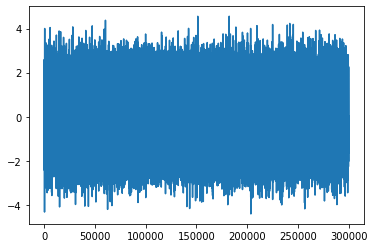

In [4]:
plt.plot(alpha_0)

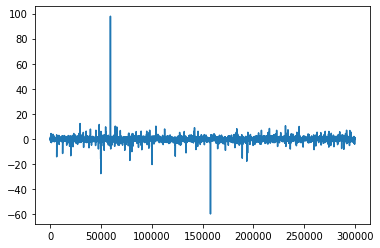

In [5]:
plt.plot(alpha)

In [6]:
# Set up the function R(x)

# X_R is the first parameter of the resistance. It is lognormally dist. 
mu_XR = 90e3 
s_XR = 4.5e3
F_XR = np.random.rand(N)

# create the random samples for both distributions parameter sets
X_XR = LogNormDist(2, F_XR, mu_XR, s_XR)
X_R_0 = stats.norm.ppf(F_XR, loc = 0, scale = 1);

# STR is 2. param of resistance 
mu_STR = 1 
s_STR = 0.03
F_STR = np.random.rand(N)
# create samples

X_STR = LogNormDist(2, F_STR, mu_STR, s_STR)
X_STR_0 = stats.norm.ppf(F_STR, loc = 0, scale = 1);

# 
mu_GEOM = 1 
s_GEOM = 0.03
F_GEOM = np.random.rand(N)
X_GEOM = LogNormDist(2, F_GEOM, mu_GEOM, s_GEOM)

X_GEOM_0 = stats.norm.ppf(F_GEOM, loc = 0, scale = 1);

X = np.vstack((u,sigmaU,alpha,X_XR,X_STR,X_GEOM))
X_0 = np.vstack((u_0,sigmaU_0,alpha_0,X_R_0,X_STR_0,X_GEOM_0))

S0 = np.zeros((N,3));

S0[:,0] = X[0,:].T;
S0[:,1] = X[1,:].T;
S0[:,2] = X[2,:].T;

S = MysteriousLoadFunc(S0);
R = X_XR*X_GEOM*X_STR;

G = np.zeros((N,1));

for i in range(0,N):
    G[i,0] = R[i] - S[i];
    
limit_state_mask = G[:,0]<0;


Failure probability = 0.2133%
Failure number = 640


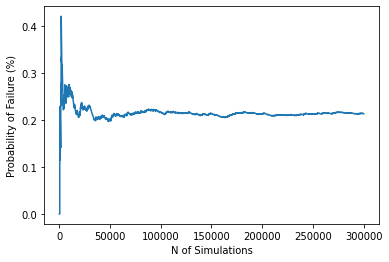

In [7]:
#Failure

fail_num = np.zeros((N,1));
fail_prob = np.zeros((N,1));
fail_num = np.cumsum(G[:,0]<0);
fail_prob = fail_num/(np.arange(N)+1);

print('Failure probability = ' + str((100 * fail_prob[-1]).round(4)) + '%');
print('Failure number = ' + str(fail_num[-1]))

plt.rc('font', size=10) 
plt.plot(fail_prob*100);
plt.xlabel('N of Simulations')
plt.ylabel('Probability of Failure (%)')
plt.show()

/tmp/ipykernel_49060/3501141620.py:6: RuntimeWarning: invalid value encountered in log
  MuAlphaFunc = lambda u: 0.088*(np.log(u) - 1) #takes u, yields mu_alpha


Probability of failure: [0.00000000e+00 3.33333333e-06 3.33333333e-06 ... 3.33333333e-06
 0.00000000e+00 6.66666667e-06]


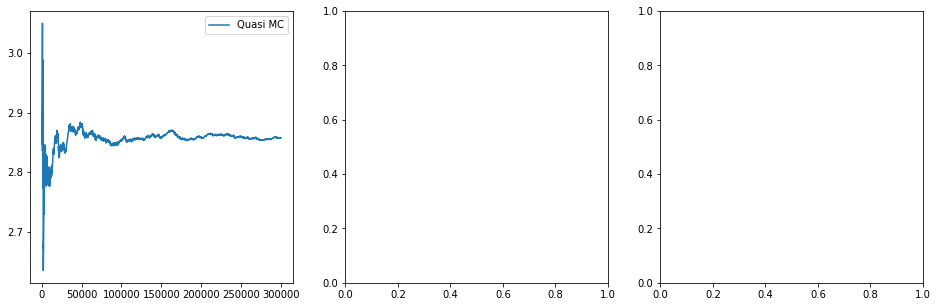

In [8]:
# Try Monte Carlo with other sampling techniques (Quasi-MC)

import chaospy as cp # Also possible with tensorflow-probabilistic

MarginalDist1 = cp.Uniform(0,1) # Marginal distribution
D1 = cp.Iid(MarginalDist1,20) # 2-D variable with i.i.d. uniform marginals
uQMC = D1.sample(N, rule = "H") # Quasi-random sequence: Halton sequence

u1QMC = stats.norm.ppf(uQMC[0,:])
u2QMC = stats.norm.ppf(uQMC[1,:])

gQMC = MuAlphaFunc(np.concatenate([[u1QMC],[u2QMC]]))

print("Probability of failure: " + str(sum(gQMC<=0)/N))

betaMChist = stats.norm.ppf(1 - np.cumsum(G<=0)/np.arange(1,len(G)+1))
betaQMChist = stats.norm.ppf(1 - np.cumsum(G<=0)/np.arange(1,len(G)+1))


fig1,axs1 = plt.subplots(1,3,figsize = (16,5))
axs1[0].plot(betaQMChist, label = 'Quasi MC')
axs1[0].legend()
plt.show()

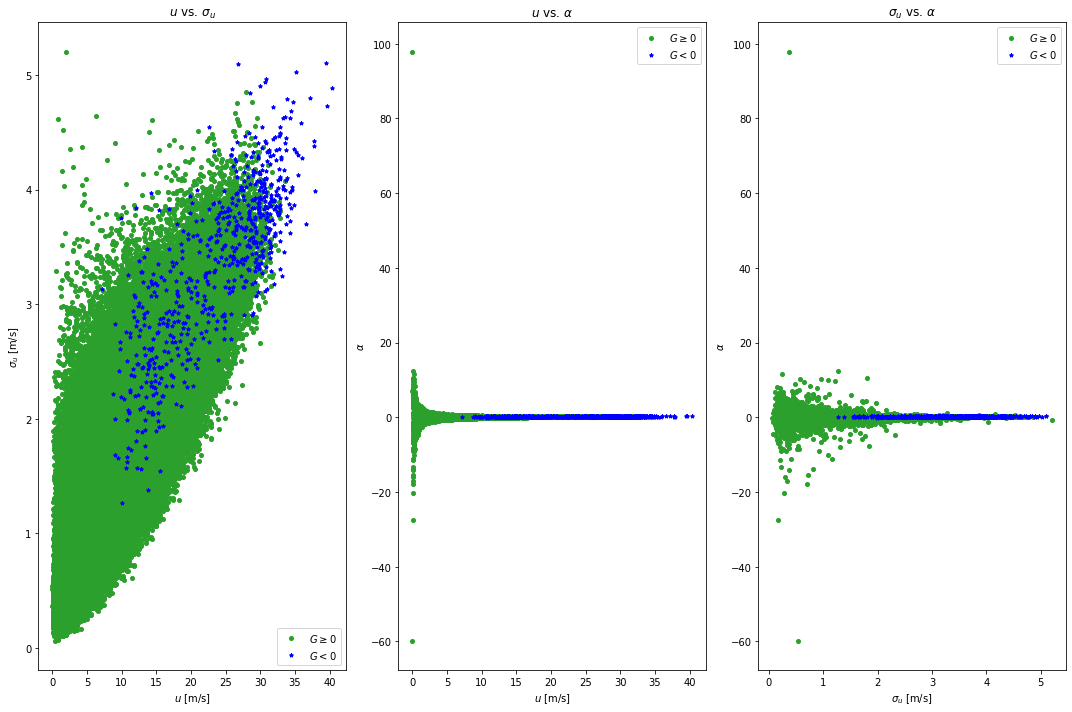

In [9]:
#%% plot with wind variables

plt.rc('font', size=10) 
fig3,axs3 = plt.subplots(1,3,figsize = (15,10))
plt.setp(axs3[0], title = '$u$ vs. $\sigma_{u}$', xlabel = '$u$ [m/s]',ylabel = '$\sigma_{u}$ [m/s]')
plt.setp(axs3[1], title = '$u$ vs. $\\alpha$', xlabel = '$u$ [m/s]',ylabel = '$\\alpha$')
plt.setp(axs3[2], title = '$\sigma_{u}$ vs. $\\alpha$', xlabel = '$\sigma_{u}$ [m/s]',ylabel = '$\\alpha$')
axs3[0].plot(X[0,G.squeeze() >= 0],X[1,G.squeeze() >= 0],'o',markersize = 4,color = 'C2')
axs3[0].plot(X[0,G.squeeze() < 0],X[1,G.squeeze() < 0],'*',markersize = 4,color = 'blue')
axs3[0].legend(['$G \geq 0$','$G < 0$'])
axs3[1].plot(X[0,G.squeeze() >= 0],X[2,G.squeeze() >= 0],'o',markersize = 4,color = 'C2')
axs3[1].plot(X[0,G.squeeze() < 0],X[2,G.squeeze() < 0],'*',markersize = 4,color = 'blue')
axs3[1].legend(['$G \geq 0$','$G < 0$'])
axs3[2].plot(X[1,G.squeeze() >= 0],X[2,G.squeeze() >= 0],'o',markersize = 4,color = 'C2')
axs3[2].plot(X[1,G.squeeze() < 0],X[2,G.squeeze() < 0],'*',markersize = 4,color = 'blue')
axs3[2].legend(['$G \geq 0$','$G < 0$'])
plt.tight_layout()             
plt.show()

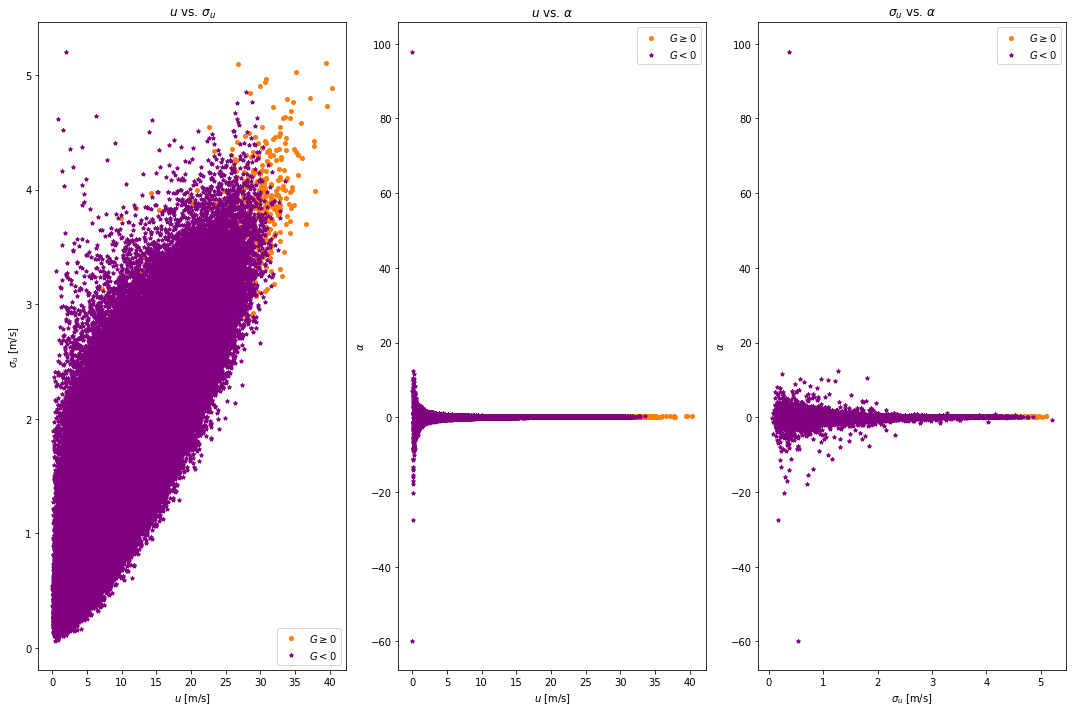

In [10]:
#%% 

plt.rc('font', size=10) 
fig3,axs3 = plt.subplots(1,3,figsize = (15,10))
plt.setp(axs3[0], title = '$u$ vs. $\sigma_{u}$', xlabel = '$u$ [m/s]',ylabel = '$\sigma_{u}$ [m/s]')
plt.setp(axs3[1], title = '$u$ vs. $\\alpha$', xlabel = '$u$ [m/s]',ylabel = '$\\alpha$')
plt.setp(axs3[2], title = '$\sigma_{u}$ vs. $\\alpha$', xlabel = '$\sigma_{u}$ [m/s]',ylabel = '$\\alpha$')
axs3[0].plot(X[0,G.squeeze() < 0],X[1,G.squeeze() < 0],'o',markersize = 4,color = 'C1')
axs3[0].plot(X[0,G.squeeze() >= 0],X[1,G.squeeze() >= 0],'*',markersize = 4,color = 'purple')
axs3[0].legend(['$G \geq 0$','$G < 0$'])
axs3[1].plot(X[0,G.squeeze() < 0],X[2,G.squeeze() < 0],'o',markersize = 4,color = 'C1')
axs3[1].plot(X[0,G.squeeze() >= 0],X[2,G.squeeze() >= 0],'*',markersize = 4,color = 'purple')
axs3[1].legend(['$G \geq 0$','$G < 0$'])
axs3[2].plot(X[1,G.squeeze() < 0],X[2,G.squeeze() < 0],'o',markersize = 4,color = 'C1')
axs3[2].plot(X[1,G.squeeze() >= 0],X[2,G.squeeze() >= 0],'*',markersize = 4,color = 'purple')
axs3[2].legend(['$G \geq 0$','$G < 0$'])
plt.tight_layout()             
plt.show()

In [11]:
#G(X) with mysterious load func

def G_mysterious(X):

    # Define functions (inline functions for conditional distribution parameters)

    Iref = 0.14; 

    #--> for shear alpha
    MuAlphaFunc = lambda u: 0.088*(np.log(u) - 1) #takes u, yields mu_alpha
    SigmaAlphaFunc = lambda u: 1/u

    #--> for turbulence sigma
    MuSigmaFunc = lambda u: Iref*(0.75*u + 3.8)
    SigmaSigmaU = 2.8*Iref

    Fu = NormalDist(1, X[0], mu=0, sigma=1); # NormalDist(1, 0, mu=0, sigma=1) = 0.5 

    #-->params for Weibull distribution of U
    Aweib = 11.28
    Kweib = 2
    u = stats.weibull_min.ppf(Fu,c = Kweib,scale = Aweib) # uses the weibull function to yield a large number of data
    u = np.atleast_2d(u);

    # calculate params for other 2 distributions, mu and sigma each
    muSigma = MuSigmaFunc(u)
    sigmaSigma = SigmaSigmaU*np.ones(muSigma.shape)

    Fsigma = np.random.rand(N) # create new random sample
    sigmaU = LogNormDist(2,Fsigma,muSigma,sigmaSigma) #draw monte carlo samples from distibution
    sigmaU = np.atleast_2d(sigmaU);

    muAlpha = MuAlphaFunc(u)
    sigmaAlpha = SigmaAlphaFunc(u)
    Falpha = np.random.rand(N)
    alpha = NormalDist(2,Falpha,muAlpha,sigmaAlpha)
    alpha = np.atleast_2d(alpha);
    
     
    input_var = np.zeros((1,3));
    input_var[0,0] = u[0,0]
    input_var[0,1] = sigmaU[0,0]
    input_var[0,2] = alpha[0,0]
    
    Sx = MysteriousLoadFunc(input_var);
    
    mu_XR = 90e3 
    s_XR = 4.5e3
    F_XR = NormalDist(1, X[3], mu=0, sigma=1);
    X_XR = LogNormDist(2, F_XR, mu_XR, s_XR)

    mu_STR = 1 
    s_STR = 0.03
    F_STR = NormalDist(1, X[4], mu=0, sigma=1);
    X_STR = LogNormDist(2, F_STR, mu_STR, s_STR)

    mu_GEOM = 1 
    s_GEOM = 0.03
    F_GEOM = NormalDist(1, X[5], mu=0, sigma=1);
    X_GEOM = LogNormDist(2, F_GEOM, mu_GEOM, s_GEOM)
    
    Rx = X_XR*X_GEOM*X_STR;
    
    
    Limit_State = Rx - Sx;
    
    return Limit_State
    

In [12]:
# FORM solution - with analytical gradients as well as with finite-difference gradients

u0 = np.array([4,0,0,0,0,0])
go = 1 #checker

g0 = G_mysterious(u0)
gradg0 = scipy.optimize.approx_fprime(u0,G_mysterious,0.000001) #FDM
itercount = 0
maxiter = 50
tol = 1e-4

ui = u0 # for the first iteration
betai = np.linalg.norm(u0)

while go == 1:
    itercount+= 1
    gi = G_mysterious(ui)
    gradgi = scipy.optimize.approx_fprime(ui,G_mysterious,0.000001) #FDM
    
    lambdai = ( np.dot(gradgi.T , ui) - gi )/ ( np.dot(gradgi.T , gradgi) )
    ui_n = lambdai * gradgi;
    betai_n = np.sqrt( np.dot (ui_n.T, ui_n ) );
    
    epsilon = np.abs(betai_n - betai)
    if epsilon <= tol:
        go = 0
    elif itercount >= maxiter:
        go = 0
    else:
        ui = ui_n # update values to use in next iteration
        betai = betai_n
        
beta_FORM = betai_n;
pf_FORM = 1 - stats.norm.cdf(beta_FORM)
u_star = ui_n

print(u_star)        
print('The analysis stopped after ' + str(itercount) + ' iterations. (MysteriousLoadFunc)')
print('Probability of failure - FORM: ' + str((pf_FORM*100).round(4)) + '% (MysteriousLoadFunc)')
print('Reliability index - FORM: ' + str(beta_FORM) + ' (MysteriousLoadFunc)')  
print('Note: this is a linear approx. (MysteriousLoadFunc)')
        

[-1.17948258e-04 -4.74768796e-05 -1.23103357e-04 -7.27162447e-05
 -3.42001899e-05 -5.45992160e-05]
The analysis stopped after 17 iterations. (MysteriousLoadFunc)
Probability of failure - FORM: 49.9919% (MysteriousLoadFunc)
Reliability index - FORM: 0.00020188774506162303 (MysteriousLoadFunc)
Note: this is a linear approx. (MysteriousLoadFunc)


In [13]:
# Now we want to see, what happens when the ML model replaces the surrogate model.

In [14]:
# 1) train the model again -> save the parameters, so that we do not have to retrain every execution
# write a wrapper function for the loads of ML model to obtain loads

In [15]:
# calculate the deviation of the error. Should be normally distibuted, mu = 0, sigma -> 1 ?
# is it normally distributed ???
# -> we have to see that, if not, change mu 
# fit a gaussian to derive the parameters of the noise / error 
# add error to the loads term - >we coupled a deterministic with a statistical model! 
# That is some funny hybrid 

In [16]:
# calculate the failure probability

In [59]:
###-----------> TRAIN A MACHINE LEARNING MODEL 
# taken from last assignment, medium model was seen to be perform alright
### derive a test and training set again

#create data set
x = rosenblatt(10000)     # Inputs
y = MysteriousLoadFunc(x) # Outputs

# scale data set
x_scaled = (x - x.mean(axis=0))/x.std(axis=0)
y_scaled = (y - y.mean() ) / y.std()

# Split test and train --> test just to make sure, but should not be too necessary here. 
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(x_scaled, y_scaled, test_size=0.25, random_state=1, shuffle=True)

# Set up the models hyperparams
parameters = {'activation': 'relu',        # Rectified Linear Unit
              'learning_rate': 'adaptive', #
              'max_iter': 750,             #
              'random_state': 1,           # creates deterministic output over several executions
              'verbose': False,            # clutters output
              'early_stopping': True,      # stops when solution does not change a lot
              'n_iter_no_change': 10}

reg          = nn.MLPRegressor(hidden_layer_sizes=(100,100), **parameters) # initialize ML model
reg.fit(x_train, y_train)  # train ML model
ml_score = reg.score(x_test, y_test) # test ML model.

# ML model should now be ready to go to use to predict loads. 

# Do a prediction of the error: 
x_error_pred = rosenblatt(10000) # inputs
y_loadfunc = MysteriousLoadFunc(x_error_pred)# prediction via loadfunc -> that is unscaled


# scale it down in order to test the model
x_error_scaled = (x_error_pred - x_error_pred.mean(axis=0))/x_error_pred.std(axis=0)
y_loadfunc_scaled = (y_loadfunc - y_loadfunc.mean() ) / y_loadfunc.std()
y_ML = reg.predict(x_error_scaled) # prediction via the trained model - >  that is a scaled one
# y_ML is scaled already

# estimate errors and their distribution
if False: # this are scaled errors! 
    errors = y_ML - y_loadfunc_scaled
    errors_mean = np.mean(errors) # This should be 0 !
    errors_std = np.std(errors) # This might be 1, when standard normal dist. 
    print(f"The ML models error has a mean of : {errors_mean} and a std of {errors_std}")
    plt.hist(errors, 50)



The ML models error has a mean of : 42.31228364422028 and a std of 4046.5790831686522


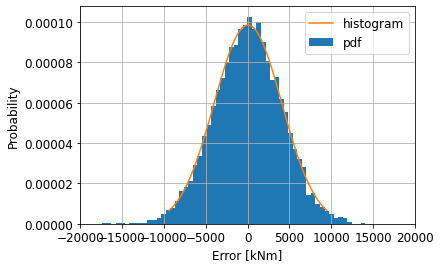

In [60]:
# Calculate errors from theloadfunction as difference 
errors = (y_ML - y_loadfunc_scaled) * y_loadfunc.std() # rescaled
errors_mean = np.mean(errors) # This should be 0 !
errors_std = np.std(errors) # This might be 1, when standard normal dist. 
loc,scale = scipy.stats.norm.fit(errors) # having obtained a lognormal fit for the errors that can be used to produce random errors

print(f"The ML models error has a mean of : {errors_mean} and a std of {errors_std}")

# get a histogram and plot the normal distribution that is fitted. 
plt.hist(errors,bins=100,density=True)#, bins=50,weights=True)
#plt.plot(errors_sorted)
plt.xlabel('Error [kNm]')
plt.ylabel('Probability')

x = np.linspace(scipy.stats.norm.ppf(0.01,loc=loc,scale=scale),scipy.stats.norm.ppf(0.99,loc=loc,scale=scale),100) # -15000,15000,10)
plt.plot(x,stats.norm.pdf(x,loc=loc,scale=scale))
plt.xlim(-20000,20000)
plt.grid()
plt.legend(['histogram','pdf'])
plt.savefig('./error_pdf.pdf', bbox_inches='tight')

In [61]:
# Make a plot for the g function sampled for myst and for ML 
if False:
    # plots for y
    fig, axs = plt.subplots(1,2)
    axs[0].scatter(x_error_pred[:,0],y_loadfunc)
    axs[1].scatter(x_error_pred[:,0],y_ML*y_loadfunc.std() + y_loadfunc.mean())


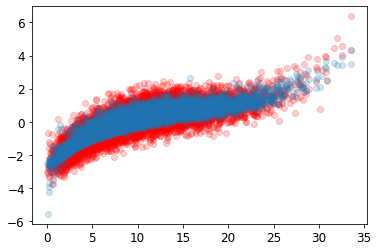

In [71]:
plt.scatter(x_error_pred[:,0],y_loadfunc_scaled,color="red", alpha=0.2)
plt.scatter(x_error_pred[:,0],y_ML,alpha = 0.2)

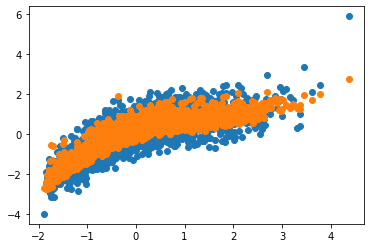

In [21]:
plt.scatter(x_test[:,0],y_test)
plt.scatter(x_test[:,0],reg.predict(x_test))

In [22]:
#len(x_error_pred)
len(x_error_pred[0])
x_error_pred.shape

(10000, 3)

In [23]:
# this does not look normally distibuted .... what to do about it ? 
# fit weibull / gumbel instead of normal dist -> I think this might be lognormal... but why is that ? 
# high error: the ML code 
errors = np.array(errors,dtype=float)
loc,scale = scipy.stats.norm.fit(errors) # having obtained a lognormal fit for the errors that can be used to produce random errors
#plt.plot(errors)

In [76]:
# create dataset to run into both load models -> S1, S2 
x_data = rosenblatt(len(X_XR)) # data as long as the resistance data from before
#X_XR # are the additional distributed values (resistance) for g
#X_STR 
#X_GEOM 


# scale the data up !
# data is scaled by std -> how to revert this ? ask moritz or google

g_loadfunc_samples =  X_XR * X_GEOM * X_STR - MysteriousLoadFunc(x_data)  
g_ML_samples =  X_XR * X_GEOM * X_STR - (y_loadfunc.std() * reg.predict((x_data - x_error_pred.mean(axis=0))/x_error_pred.std(axis=0))  + y_loadfunc.mean())   # NEEDS TO BE RESCALED! 
#g_ML_corrected_samples =  X_XR * X_GEOM * X_STR - (y_loadfunc.std() * reg.predict((x_data - x_error_pred.mean(axis=0))/x_error_pred.std(axis=0))  + y_loadfunc.mean())  - scipy.stats.norm.rvs(loc=loc,scale=scale,size=len(X_XR)) # NEEDS TO BE RESCALED! 
g_ML_corrected_samples =  X_XR * X_GEOM * X_STR - (y_loadfunc.std() * reg.predict((x_data - x_error_pred.mean(axis=0))/x_error_pred.std(axis=0))  + y_loadfunc.mean())  - scipy.stats.norm.rvs(loc=loc,scale=scale,size=len(X_XR)) # NEEDS TO BE RESCALED! 
#g_ML_corrected_samples =  X_XR * X_GEOM * X_STR - reg.predict(x_data) - scipy.stats.norm.rvs(loc=loc,scale=scale,size=len(X_XR))

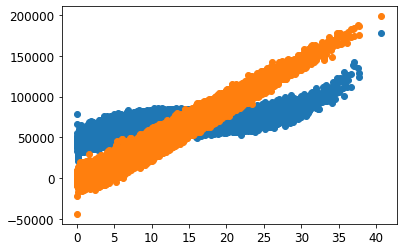

In [83]:
plt.scatter(x_data[:,0],MysteriousLoadFunc(x_data))
plt.scatter(x_data[:,0], y_loadfunc.std() * reg.predict(x_data) - scipy.stats.norm.rvs(loc=loc,scale=scale,size=len(X_XR) )) # needs scaling

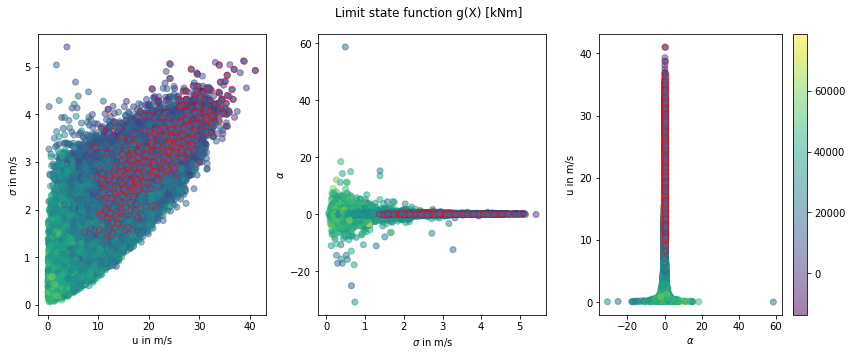

In [25]:
# plot limit state function for the corrected model
G_mlf = g_ML_corrected_samples
fail_mlf = G_mlf < 0
wind = x_data
alpha = 0.5
fig, axs = plt.subplots(1, 3, figsize=(12, 5))
axs[0].scatter(wind[:, 0], wind[:, 1], alpha=alpha, c=G_mlf)
axs[0].scatter(wind[fail_mlf, 0], wind[fail_mlf, 1], alpha=alpha, edgecolor='r', linewidth=1)
axs[0].set_xlabel('u in m/s')
axs[0].set_ylabel(r'$\sigma$ in m/s')

axs[1].scatter(wind[:, 1], wind[:, 2], alpha=alpha, c=G_mlf)
axs[1].scatter(wind[fail_mlf, 1], wind[fail_mlf, 2], alpha=alpha, edgecolor='r', linewidth=1)
axs[1].set_xlabel(r'$\sigma$ in m/s')
axs[1].set_ylabel(r'$\alpha$')

axs[2].scatter(wind[:, 2], wind[:, 0], alpha=alpha, c=G_mlf)
s=axs[2].scatter(wind[fail_mlf, 2], wind[fail_mlf, 0], alpha=alpha, edgecolor='r', linewidth=1)
axs[2].set_xlabel(r'$\alpha$')
axs[2].set_ylabel('u in m/s')

s.set_clim(G_mlf.min(), G_mlf.max())
fig.colorbar(s)
plt.suptitle("Limit state function g(X) [kNm]")
plt.tight_layout()
#plt.savefig('g.pdf')
plt.savefig('g_ml_corrected.png')

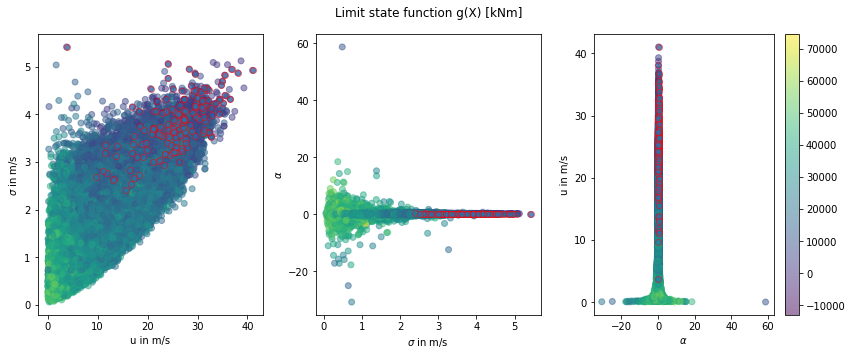

In [26]:
# plot limit state function for the corrected model
G_mlf = g_ML_samples
fail_mlf = G_mlf < 0
wind = x_data
alpha = 0.5
fig, axs = plt.subplots(1, 3, figsize=(12, 5))
axs[0].scatter(wind[:, 0], wind[:, 1], alpha=alpha, c=G_mlf)
axs[0].scatter(wind[fail_mlf, 0], wind[fail_mlf, 1], alpha=alpha, edgecolor='r', linewidth=1)
axs[0].set_xlabel('u in m/s')
axs[0].set_ylabel(r'$\sigma$ in m/s')

axs[1].scatter(wind[:, 1], wind[:, 2], alpha=alpha, c=G_mlf)
axs[1].scatter(wind[fail_mlf, 1], wind[fail_mlf, 2], alpha=alpha, edgecolor='r', linewidth=1)
axs[1].set_xlabel(r'$\sigma$ in m/s')
axs[1].set_ylabel(r'$\alpha$')

axs[2].scatter(wind[:, 2], wind[:, 0], alpha=alpha, c=G_mlf)
s=axs[2].scatter(wind[fail_mlf, 2], wind[fail_mlf, 0], alpha=alpha, edgecolor='r', linewidth=1)
axs[2].set_xlabel(r'$\alpha$')
axs[2].set_ylabel('u in m/s')

s.set_clim(G_mlf.min(), G_mlf.max())
fig.colorbar(s)
plt.suptitle("Limit state function g(X) [kNm]")
plt.tight_layout()
#plt.savefig('g.pdf')
plt.savefig('g_ml.png')

In [27]:
# Train a model for g? train on the input and loads data from MC, then try to predict g ? 
n_fail_loadfunc = sum(g_loadfunc_samples < 0) / len(X_XR)
n_fail_ML = sum(g_ML_samples < 0) / len(X_XR)
n_fail_ML_corrected = sum(g_ML_corrected_samples < 0) / len(X_XR)

# Propabilities of failure
print(f"The fail probabilities are: \n using Loadfunc:\t {n_fail_loadfunc}\n \
using ML:\t {n_fail_ML}\n using ML corrected: \t{n_fail_ML_corrected}")

The fail probabilities are: 
 using Loadfunc:	 0.00215
 using ML:	 0.0005566666666666667
 using ML corrected: 	0.0015133333333333333


In [28]:
len(X_XR)

300000

In [29]:
# SUCCESS ! -> Now that this works, maybe fit a model on the g function ? 

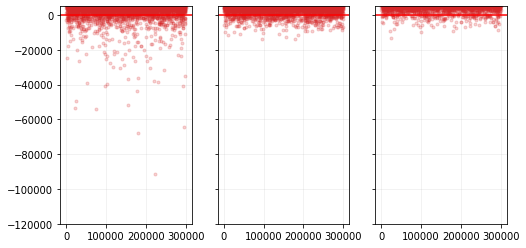

In [30]:
fig, axs = plt.subplots(1,3, sharey=True, figsize=(8,4))

axs[0].plot(g_loadfunc_samples,linestyle='None',marker='.',color='tab:red',alpha=0.2)
axs[0].axhline(0, color='red')
axs[0].grid(alpha=0.2)
axs[0].set_ylim((-120000,5000))

axs[1].plot(g_ML_corrected_samples,linestyle='None',marker='.',color='tab:red',alpha=0.2)
axs[1].axhline(0, color='red')
axs[1].grid(alpha=0.2)



axs[2].plot(g_ML_samples,linestyle='None',marker='.',color='tab:red',alpha=0.2)
axs[2].axhline(0, color='red')
axs[2].grid(alpha=0.2)


645
454
167


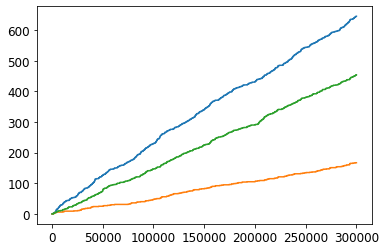

In [55]:
print(sum(g_loadfunc_samples <0))
print(sum(g_ML_corrected_samples <0))
print(sum(g_ML_samples <0))

fails_lf = np.cumsum(g_loadfunc_samples <0)
fails_ml_u = np.cumsum(g_ML_samples <0)
fails_ml = np.cumsum(g_ML_corrected_samples <0)

plt.plot(fails_lf)
plt.plot(fails_ml_u)
plt.plot(fails_ml)

p_lf = 

In [101]:
### --------------> TRAIN A ML MODEL ON THE G FUNCTION
#
#
#
#
#


Failure probability = 0.2133%
Failure number = 640


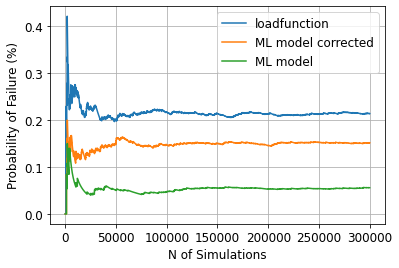

In [56]:
#Failure

fail_num = np.zeros((N,1));
fail_prob = np.zeros((N,1));
fail_num = np.cumsum(G[:,0]<0);
fail_prob = fail_num/(np.arange(N)+1);

fail_num_ML = np.cumsum(g_ML_corrected_samples<0)
fail_prob_ML = fail_num_ML/(np.arange(N)+1) 

fail_num_ML_u = np.cumsum(g_ML_samples<0)
fail_prob_ML_u = fail_num_ML_u/(np.arange(N)+1) 



print('Failure probability = ' + str((100 * fail_prob[-1]).round(4)) + '%');
print('Failure number = ' + str(fail_num[-1]))

plt.rc('font', size=12) 
plt.plot(fail_prob*100, label='loadfunction');
plt.plot(fail_prob_ML*100, label='ML model corrected');
plt.plot(fail_prob_ML_u*100, label='ML model');
plt.grid()
plt.legend()
plt.xlabel('N of Simulations')
plt.ylabel('Probability of Failure (%)')
plt.show()

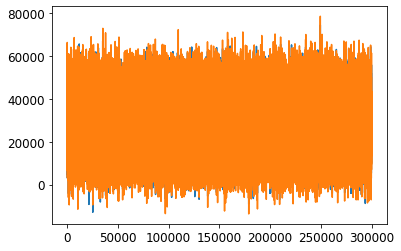

In [41]:
plt.plot(g_ML_samples)
plt.plot(g_ML_corrected_samples)

In [45]:
fail_num_ML = np.cumsum(g_ML_corrected_samples<0)
fail_prob_ML = fail_num_ML/(np.arange(N)+1) 
print(g_ML_corrected_samples<0)
print(fail_prob_ML)
fail_num_ML_u = np.cumsum(g_ML_samples<0)
fail_prob_ML_u = fail_num_ML/(np.arange(N)+1) 
print(fail_prob_ML_u)

[False False False ... False False False]
[0.         0.         0.         ... 0.00151334 0.00151334 0.00151333]
[0.         0.         0.         ... 0.00151334 0.00151334 0.00151333]
